# Volcanics Image Classification
Author: Tyler Newton  
Credit: some borrowed content from [Ben Trevett's image classification notebook](https://github.com/bentrevett/pytorch-image-classification)

### Test image directory:
Dropbox/Research/ML_image_classification/notebooks/data/train\
and\
Dropbox/Research/ML_image_classification/notebooks/data/test 

### Actual image directory:
Volumes/newton_6TB/A_ML_Picked/Cltwd_5A_PICKED/  

## Implement transfer learning on ResNet for volcanic sample classification
[ResNet](https://arxiv.org/abs/1512.03385) won the [ImageNet](https://www.image-net.org/challenges/LSVRC/) challenge in 2015. ResNet is an [artificial neural network](https://en.wikipedia.org/wiki/Artificial_neural_network), specifically it is a [residual neural network](https://en.wikipedia.org/wiki/Residual_neural_network), which is a clever case of a [highway network](https://en.wikipedia.org/wiki/Highway_network). The basic structure of a ResNet is blocks of batch normalization layers, convolutional layers, and residual connections. The residual connections (a way of skipping layers) allow reduction of model complexity for input to output mapping that requires fewer layers. In the cells below, transfer learning with discriminative fine tuning and [superconvergence](https://arxiv.org/abs/1803.09820) is implemented on a pre-trained ResNet for the purpose of classifying visible-light images of volcanic samples. Transfer learning allows us to build on the high-level features, like edges and textures, that a pre-trained model has already learned to identify from a large dataset (ImageNet).

### Model log:  
* 50-10-model.pt: 50 layers, 10 epochs
    * Batch size: 64
    * Train Loss: 0.050 | Train Acc:  97.81%
	* Valid Loss: 0.397 | Valid Acc:  87.50%
    * Test Loss: 0.548 | Test Acc:  85.94%
* 50-10-32-model.pt: 50 layers, 10 epochs
    * Batch size: 32
    * Train Loss: 0.063 | Train Acc:  98.27%
	* Valid Loss: 0.318 | Valid Acc:  84.38%
    * Test Loss: 0.409 | Test Acc:  86.46%
* 50-100-model.pt: 50 layers, 100 epochs
    * Batch size: 64
    * Train Loss: 0.048 | Train Acc:  98.12%
	* Valid Loss: 0.248 | Valid Acc:  89.84%
    * Test Loss: 0.399 | Test Acc:  90.62%
* 50-50-model.pt: 50 layers, 50 epochs
    * Batch size: 64
    * Train Loss: 0.004 | Train Acc: 100.00%
	* Valid Loss: 0.319 | Valid Acc:  93.75%
    * Test Loss: 0.510 | Test Acc:  86.46%

In [1]:
# model name is layers-epochs
MODEL_NAME = "50-50-model.pt"
EPOCHS = 50
BATCH_SIZE = 64

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

# set random seeds for reproducability
SEED = 7427

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# set train/test ratio and split data into train/test directories
TRAIN_RATIO = 0.8

# now the data is split per the specified train/test ratio into train and test directories
ROOT = "/Users/human/Dropbox/Research/ML_image_classification/notebooks/data"
images_dir = os.path.join(ROOT, 'full_dataset')
train_dir = os.path.join(ROOT, 'train')
test_dir = os.path.join(ROOT, 'test')
        
# transform data to same size and normalization as the data the pre-trained model was trained with
# listed here: https://pytorch.org/docs/stable/torchvision/models.html
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

# data are randomly cropped, flipped horizontally, and rotated for the train and test sets
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)])
test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)])

# load transformed data
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

# generate validation split
VALID_RATIO = 0.9
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

# overwrite validation transforms
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# print the counts
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 597
Number of validation examples: 67
Number of testing examples: 170


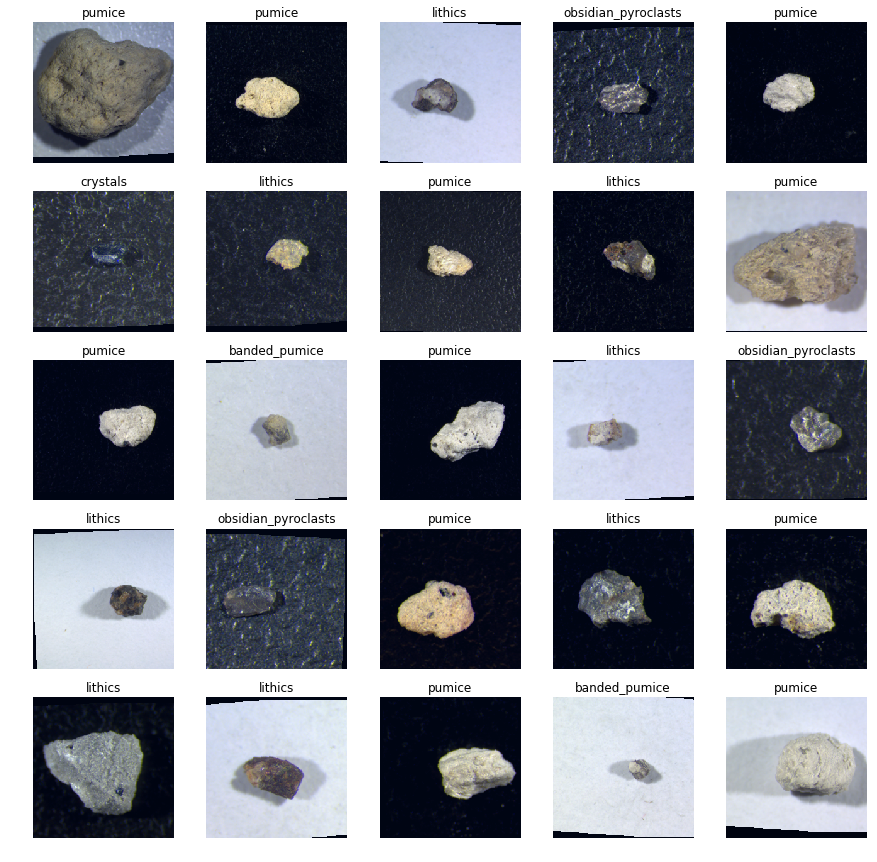

In [3]:
# create iterators with appropriate batch size
train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

# plot some images to check that everything es bueno 
# function to renormalize image
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image  

# function to plot image
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')
        
    plt.savefig("samples.png", bbox_inches='tight')
        
# plot the transformed images
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

In [4]:
# build the ResNet
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

# build basic blocks consisting of 3x3 convolutional layers
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

# build bottleneck block, only used for 50, 101, and 152 layer models
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

# specify ResNet configuration in block class, number of blocks in each layer, and number of channels in each layer
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

# configure ResNets of 18, 34, 50, 101, and 152 layers
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

# pick a model, 152 layer model specified below
pretrained_model = models.resnet50(pretrained = True)
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# rescale 1000 dimension output to the output of volcanics images
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

# replace linear layer with correct dimensions
pretrained_model.fc = fc

# initialize model and check state
model = ResNet(resnet50_config, OUTPUT_DIM)
model.load_state_dict(pretrained_model.state_dict())

# check number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,518,277 trainable parameters


In [ ]:
# define a learning rate optimizer for training
# start with a low rate
START_LR = 1e-7

# define optimizer, device, and loss function
optimizer = optim.Adam(model.parameters(), lr=START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

# assign to model
model = model.to(device)
criterion = criterion.to(device)

# define learning rate finder class
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

# define the learning rate finder and run range test
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

# function to plot range test results
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [ ]:
# set learning rate based on above plot: choose the middle of the steepest descent
FOUND_LR = 1e-3

# set up discriminative fine tuning
params = [{'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}]

optimizer = optim.Adam(params, lr = FOUND_LR)

# set up one cycle learning rate scheduler
# EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LRS, total_steps = TOTAL_STEPS)

# regular accuracy, not top-k
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# define training function
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

# evaluation function with accuracy
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
        
    return epoch_loss, epoch_acc

# function to track epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# train model and display validation accuracy
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')

In [ ]:
# analyze loss
model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')

In [ ]:
# inspect the model
# function to fetch the predictions
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

# get predicted labels
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

# function for confusion matrix
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10)); # was 50, 50
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    # plt.xticks(fontsize=20)
    plt.xlabel('Predicted Label', fontsize = 20) # was 50
    plt.ylabel('True Label', fontsize = 20) # was 50
    plt.savefig(MODEL_NAME[:-3]+"_confusion.png", bbox_inches='tight')
    
# check that diagonals are darker than rest of matrix
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
# inspect incorrect predictions
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
print(len(incorrect_examples))

# function to plot incorrect predictions
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)
    plt.savefig(MODEL_NAME[:-3]+"_incorrect.png")

# number of images to plot
N_IMAGES = 25

# plot them
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
# perform dimensionality reduction

# function to get representations
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

outputs, labels = get_representations(model, train_iterator)

# function for pca
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

# function for plotting representations
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    color_nums = [idx+1 for idx, _ in enumerate(np.unique(labels))]
    color_nums /= np.max(np.abs(color_nums),axis=0)
    legend_elements = []
    for index, group in enumerate(np.unique(labels)):
        indices = np.where(labels == group)
        #color_num = np.ravel(np.asarray([color_nums[index] for i in range(len(data[indices,0][0]))]))
        color_num = data[indices, 0]
        color_num.fill(color_nums[index])
        ax.scatter(data[indices, 0], data[indices, 1], c = color_num, cmap = 'hsv', vmin=0, vmax=1)
        colmap = matplotlib.cm.get_cmap('hsv')
        rgba = colmap(color_nums[index])
        legend_elements.append(Line2D([0], [0], marker='o', color=rgba, label=classes[group], markerfacecolor=rgba, markersize=15))
    legend = plt.legend(handles=legend_elements)
    plt.savefig(MODEL_NAME[:-3]+"_pca.png")
    
# check that classes are well-separated
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [ ]:
# perform t-SNE
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

def plot_tsne(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    color_nums = [idx+1 for idx, _ in enumerate(np.unique(labels))]
    color_nums /= np.max(np.abs(color_nums),axis=0)
    legend_elements = []
    for index, group in enumerate(np.unique(labels)):
        indices = np.where(labels == group)
        #color_num = np.ravel(np.asarray([color_nums[index] for i in range(len(data[indices,0][0]))]))
        color_num = data[indices, 0]
        color_num.fill(color_nums[index])
        ax.scatter(data[indices, 0], data[indices, 1], c = color_num, cmap = 'hsv', vmin=0, vmax=1)
        colmap = matplotlib.cm.get_cmap('hsv')
        rgba = colmap(color_nums[index])
        legend_elements.append(Line2D([0], [0], marker='o', color=rgba, label=classes[group], markerfacecolor=rgba, markersize=15))
    legend = plt.legend(handles=legend_elements)
    plt.savefig(MODEL_NAME[:-3]+"_tsne.png")

# check that classes are well-separated
output_tsne_data = get_tsne(outputs)
plot_tsne(output_tsne_data, labels, classes)

In [ ]:
# check how images look after first convolutional layer
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)
    plt.savefig(MODEL_NAME[:-3]+"_filters.png")
    
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [ ]:
# check filter values
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

# plot filters and adjust learning rate if features are insufficient
plot_filters(filters)